In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import thunder as td
from fish.util.fileio import load_image
from glymur import jp2k
%matplotlib inline

In [3]:
def guess_experimenter(fname):
        if fname.find('Yu') > 0:
            return 'yu'
        elif fname.find('davis') > 0:
            return 'davis'
        else:
            return ''

In [4]:
base_dirs = ('/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/',)

# do different things to the directories depending on whether data are davis' or yu's
paths = dict()
cur_exp = -1
paths['base'] = base_dirs[cur_exp]
experimenter = guess_experimenter(paths['base'])

bidirectional_stack=False

if experimenter is 'yu':
    print('These data are from Yu.')
    paths['raw'] = paths['base'] + 'raw/'
    paths['proj'] = paths['base'] + 'projections/'
    paths['reg'] = paths['base']    

elif experimenter is 'davis':
    print('These data are from Davis')    
    paths['raw'] = paths['base']
    paths['proc'] = paths['raw'].replace('raw', 'proc')
    paths['proj'] = paths['proc'] + 'proj/'
    paths['reg'] = paths['proc'] + 'reg/'

# Get the camera background image
background_im_fname = paths['raw'] + 'Background_0.tif'
background_im = jp2k.Jp2k(background_im_fname)[:]

fnames = glob(paths['raw'] + 'TM*')
fnames.sort()    
print('Num raw images: {0}'.format(len(fnames)))

from fish.image.vol import get_stack_freq
fs_im = 1 / get_stack_freq(paths['raw'])[0]    
print('Sampling rate:  {0} Hz'.format(1 / fs_im))

# set correct aspect ratio for plotting
from fish.image.vol import get_metadata
exp_data = get_metadata(paths['raw'] + 'ch0.xml')
bidirectional_stack = exp_data['bidirectional_stack'] == 'T'
z_step = exp_data['z_step']
aspect = (int(z_step / .406), 1, 1)

from os.path import exists
if not exists(paths['proj']):
    from os import makedirs
    makedirs(paths['proj'])
else:
    print('Num existing projections: {0}'.format(len(glob(paths['proj'] + 't*'))))
print('Bidirectional stack : {0}'.format(bidirectional_stack))

These data are from Yu.
Num raw images: 7200
Sampling rate:  1.58 Hz
Num existing projections: 7200
Bidirectional stack : False


In [179]:
plr = slice(0, None)
ims = td.images.fromlist(fnames[plr], accessor=load_image, engine=sc, npartitions=len(fnames[plr])).median_filter(size=(1,3,3)).astype('float32')
if bidirectional_stack:
    from fish.image.vol import rearrange_bidirectional_stack
    ims = ims.map(rearrange_bidirectional_stack)

In [180]:
ims.shape

(7200, 29, 2048, 2048)

In [181]:
%%time
do_registration = False

if not exists(paths['reg']):
    ref_range = (len(fnames) // 2) + np.arange(-5,5)
    ref = td.images.fromlist(np.array(fnames)[ref_range], accessor=load_image)
    ref = ref.median_filter(size=(1,3,3)).mean().toarray().astype('uint16')

    if bidirectional_stack:
        ref = rearrange_bidirectional_stack(ref)

    # save reference image to disk 
    from skimage.io import imsave

    makedirs(paths['reg'])
    imsave(paths['reg'] + 'anat_reference.tif', ref, compress=1)
else:
    from skimage.io import imread
    ref = imread(paths['reg'] + 'anat_reference.tif')

try:
    affs = np.load(paths['reg'] + 'regparams_affine.npy')
    affs = affs[plr]
    print('Registration params found')
except(FileNotFoundError):
    print('Registration params not found, performing registration')
    do_registration = True

if do_registration:
    from fish.image.alignment import estimate_translation
    reg = ims.map(lambda v: estimate_translation(ref.max(0), v.max(0))).toarray()
    affs = np.array([r.affine for r in reg])
    np.save(paths['reg'] + 'regparams_affine.npy', affs)

Registration params found
CPU times: user 986 ms, sys: 94.1 ms, total: 1.08 s
Wall time: 1.6 s


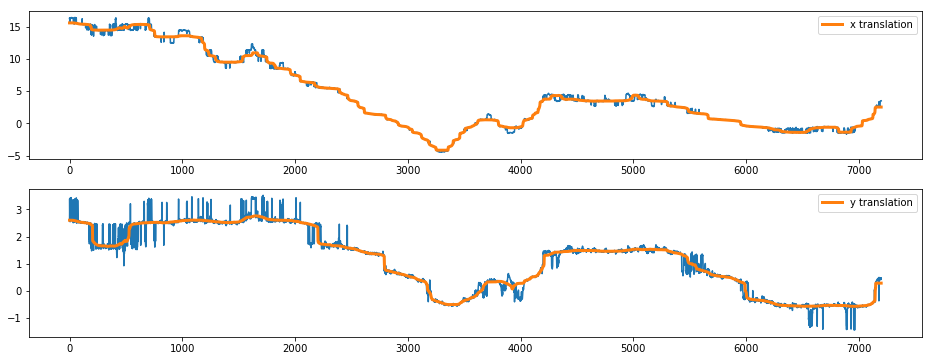

In [182]:
from scipy.ndimage.filters import median_filter
fig, axs = plt.subplots(nrows=2, figsize=(16,6))
x_trans_raw = affs[:, -2, -1]
y_trans_raw = affs[:, 0, -1]
x_trans = median_filter(x_trans_raw, size=200)
y_trans = median_filter(y_trans_raw, size=200)
z_trans = np.zeros(x_trans.shape)
trans = np.vstack([z_trans, y_trans, x_trans])

axs[0].plot(x_trans_raw)
axs[0].plot(x_trans, linewidth=3, label = 'x translation')
axs[0].legend()
axs[1].plot(y_trans_raw)
axs[1].plot(y_trans, linewidth=3, label = 'y translation')
axs[1].legend()

In [183]:
# One can estimate the background pixe levels using the peak of the histogram of the reference image
#hist = np.histogram(ref.ravel()[::100], np.arange(ref.min(), ref.max()))
#fill_val = np.round(hist[1][np.argmax(hist[0])])
fill_val = np.median(background_im)

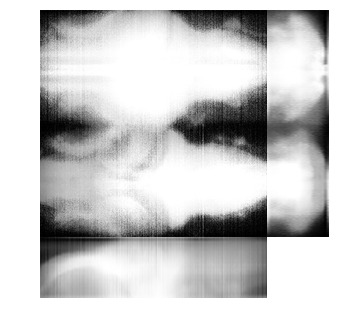

In [184]:
from fish.image.vol import proj_plot
mask = ref > fill_val
proj_plot(mask, np.mean, aspect=aspect);

In [185]:
from scipy.ndimage.interpolation import shift

# important to apply -1 * translation
ims_registered = ims.map(lambda v: shift(v[1], -trans[:, v[0][0]], cval=fill_val), with_keys=True).astype('float32')

In [186]:
# generate local projections 
def my_proj(v, slab_size = 4, axis=0):    
    from fish.image.vol import sub_proj    
    from numpy import amax
    # number of planes per projection        
    n_slabs = int(np.ceil(v.shape[axis] / slab_size))    
    chopped = sub_proj(v, axis, amax, n_slabs)
    return chopped

from skimage.exposure import rescale_intensity as rescale

from fish.image.vol import dff

# save the images
def save_ims(kv, dest_dir):
    from skimage.io import imsave
    key = kv[0][0]
    val = kv[1]    
    fname = 't_{:06d}.tif'.format(key)
    imsave(dest_dir + fname, val, compress=1)

In [187]:
%%time
# take 300s baseline
baseline_window = int(300 / fs_im)
baseline_offset = 10
ds = 4

# subtract camera background, clip off negative values
ims_registered_bs = ims_registered.map(lambda v: np.clip(v - fill_val, a_min=0, a_max=None))

# uniform filter and downsampling
ims_ds = ims_registered_bs.uniform_filter(size=(1,ds,ds))[:,:,::ds,::ds]

#take dff
ims_dff = ims_ds.map_as_series(lambda v: dff(v, baseline_window, percentile=20, baseline_offset=baseline_offset))

# get min and max
bounds = ims_dff.map(lambda v: np.array([v.min(), v.max()])).toarray()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job 37 cancelled because Stage 97 was cancelled
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:1370)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply$mcVI$sp(DAGScheduler.scala:1358)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply(DAGScheduler.scala:1357)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply(DAGScheduler.scala:1357)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofInt.foreach(ArrayOps.scala:156)
	at org.apache.spark.scheduler.DAGScheduler.handleStageCancellation(DAGScheduler.scala:1357)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1613)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1832)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1845)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1858)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1929)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:927)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:926)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor29.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)


In [130]:
from skimage.io import imsave
sample = ims_dff[:,20].toarray()
imsave('/groups/ahrens/ahrenslab/davis/tmp/test_ims.tif', sample.astype('float32'))

## Apply dff-based mask and rescale

In [150]:
ims_dff.shape

(500, 29, 512, 512)

In [169]:
out_range = (0, 4096)
mn, mx = bounds.min(), bounds.max()
y_slab_size = ims_dff.shape[2] // 2
slabs_z = ims_dff.map(lambda v: rescale(v, (mn,mx), out_range)).map(lambda v: my_proj(v, axis=0)).astype('int16')
slabs_y = ims_dff.map(lambda v: rescale(v, (mn,mx), out_range)).map(lambda v: my_proj(v, axis=1, slab_size=y_slab_size)).astype('int16')

## Save projections

In [175]:
%%time
tmp_paths = {}
tmp_paths['y'] = '/groups/ahrens/ahrenslab/davis/tmp/20170228/projs_y/'
tmp_paths['z'] = '/groups/ahrens/ahrenslab/davis/tmp/20170228/projs_z/'
slabs_z.tordd().foreach(lambda v: save_ims(v, tmp_paths['z']))
slabs_y.tordd().foreach(lambda v: save_ims(v, tmp_paths['y']))

CPU times: user 184 ms, sys: 43.7 ms, total: 227 ms
Wall time: 9.01 s


## Save metadata

In [172]:
print(mn)
print(mx)

-0.546811
11.5211


In [176]:
metadata = {}
metadata['raw_data_path'] = paths['raw']
metadata['dff_lims'] = [float(mn), float(mx)]
metadata['spatial_downsampling'] = ds
metadata['dff_window'] = baseline_window

In [178]:
import json
#metadata_fname = paths['proj'] + 'metadata.json'
metadata_fname = tmp_paths['y'] + 'metadata.json'
with open(metadata_fname, 'w') as fp:
    json.dump(metadata, fp)
    
metadata_fname = tmp_paths['z'] + 'metadata.json'
with open(metadata_fname, 'w') as fp:
    json.dump(metadata, fp)

In [ ]:
%%bash
qdel -u bennettd